# Analyse des Clusters par la Méthode du Coude

Ce notebook implémente une analyse de clustering utilisant la méthode du coude pour déterminer le nombre optimal de clusters dans les données de retours de service au tennis de table. Il inclut :

- Détection et exclusion des outliers
- Normalisation des données
- Application de la méthode du coude
- Visualisation des clusters résultants
- Analyse statistique des clusters

## 1. Configuration et Importation des Bibliothèques

Importation de toutes les bibliothèques nécessaires pour l'analyse de clustering :

In [ ]:
import os
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Ajout du chemin des modules
chemin_dossier_parent = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Connexion à la base de données
con = sqlite3.connect("BDD_avec_cluster.db")

## 2. Chargement et Préparation des Données

Récupération des coordonnées des retours de service :

In [20]:
# Requête SQL pour récupérer les retours de service
query = """
    SELECT coor_balle_x, coor_balle_y
    FROM Liste_des_coups
    WHERE coor_balle_x IS NOT NULL 
    AND coor_balle_y IS NOT NULL
    AND num_coup = 2  -- Seulement les retours de service
    AND joueur_frappe = "ALEXIS-LEBRUN"
"""

# Chargement des données dans un DataFrame
df = pd.read_sql_query(query, con)
print("Nombre de points chargés :", len(df))
df.head()

Nombre de points chargés : 267


,coor_balle_x,coor_balle_y
0,31.746838,-117.490506
1,5.516127,-92.875505
2,-37.494410,-60.333955
3,-35.337580,-87.152068
4,-31.058079,-88.174762


## 3. Détection et Exclusion des Outliers

Préparation des données pour l'analyse en :
1. Convertissant en tableau numpy
2. Gérant les points avec y négatif
3. Normalisant les données
4. Excluant les outliers avec un seuil de z-score

In [21]:
# Conversion en array numpy et suppression des NaN
points = df.astype(float).to_numpy()
mask = ~np.isnan(points).any(axis=1)
points = points[mask]

# Inversion des coordonnées pour les points avec y négatif
for i in range(len(points)):
    if points[i, 1] < 0:
        points[i, 0] *= -1  # Inverse x
        points[i, 1] *= -1  # Inverse y

# Première normalisation pour la détection des outliers
scaler_outliers = StandardScaler()
points_scaled_for_outliers = scaler_outliers.fit_transform(points)

# Exclusion des outliers (z_threshold = 1.75)
z_threshold = 1.75
mask_inliers = np.all(
    np.abs(points_scaled_for_outliers) <= z_threshold, axis=1
)
points_clean = points[mask_inliers]

print(
    f"Points initiaux : {len(points)}, points après exclusion outliers : {len(points_clean)}"
)

# Normalisation finale sur les données nettoyées
scaler_final = StandardScaler()
points_scaled = scaler_final.fit_transform(points_clean)

Points initiaux : 267, points après exclusion outliers : 238


## 4. Application de la Méthode du Coude

Calcul de l'inertie pour différentes valeurs de k et détermination du point optimal avec KneeLocator :

In [22]:
# Calcul des inerties pour différentes valeurs de k
k_max = 21
k_range = list(range(1, k_max))
inertias = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(points_scaled)
    inertias.append(km.inertia_)

# Détection du coude avec KneeLocator
kl = KneeLocator(
    k_range,
    inertias,
    curve="convex",
    direction="decreasing",
    interp_method="polynomial",
)

elbow_point = (
    kl.knee
    or k_range[np.argmax(np.abs(np.gradient(np.gradient(np.array(inertias)))))]
)
print(f"Nombre optimal de clusters suggéré : {elbow_point}")

Nombre optimal de clusters suggéré : 4


## 5. Visualisation des Résultats

Traçage de la courbe du coude et visualisation de la distribution des clusters :

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


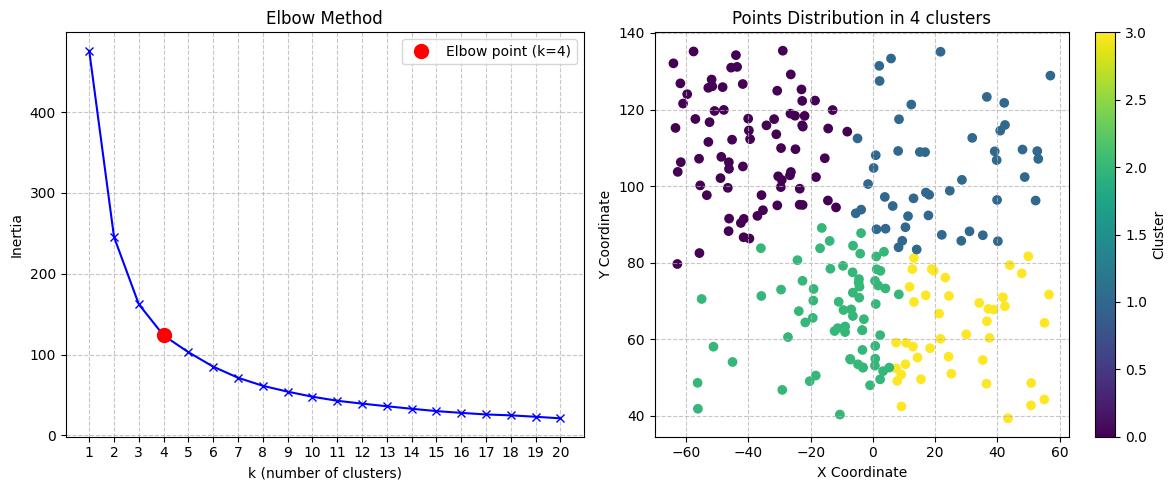

In [23]:
# Tracé de la courbe du coude
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, "bx-")
plt.plot(
    elbow_point,
    inertias[elbow_point - 1],
    "ro",
    markersize=10,
    label=f"Elbow point (k={elbow_point})",
)
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.xticks(k_range)  # Force l'affichage des valeurs entières sur l'axe x

# Clustering final et visualisation
optimal_kmeans = KMeans(n_clusters=elbow_point, random_state=42, n_init=20)
clusters = optimal_kmeans.fit_predict(points_scaled)

plt.subplot(1, 2, 2)
scatter = plt.scatter(
    points_clean[:, 0], points_clean[:, 1], c=clusters, cmap="viridis"
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title(f"Points Distribution in {elbow_point} clusters")
plt.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("images/elbow_method_clusters.eps", format="eps")
plt.show()

## 6. Analyse des Clusters

Calcul et affichage des statistiques pour chaque cluster :

In [24]:
# Statistiques des clusters
print("\nStatistiques des clusters:")
for i in range(elbow_point):
    cluster_pts = points_clean[clusters == i]
    print(f"\nCluster {i + 1}:")
    print(f"  Nombre de points : {len(cluster_pts)}")
    print(
        f"  Centre     : ({np.mean(cluster_pts[:, 0]):.2f}, {np.mean(cluster_pts[:, 1]):.2f})"
    )
    print(
        f"  Écart-type : ({np.std(cluster_pts[:, 0]):.2f}, {np.std(cluster_pts[:, 1]):.2f})"
    )

# Fermeture de la connexion à la base de données
con.close()


Statistiques des clusters:

Cluster 1:
  Nombre de points : 77
  Centre     : (-38.77, 110.42)
  Écart-type : (14.73, 13.71)

Cluster 2:
  Nombre de points : 49
  Centre     : (21.40, 103.72)
  Écart-type : (18.02, 14.11)

Cluster 3:
  Nombre de points : 69
  Centre     : (-11.91, 66.26)
  Écart-type : (15.16, 11.98)

Cluster 4:
  Nombre de points : 43
  Centre     : (27.77, 62.34)
  Écart-type : (15.42, 11.72)
